<a href="https://colab.research.google.com/github/tharunmarella/cnnProject/blob/main/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch datasets

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from segmentation_models_pytorch import Unet
from PIL import Image
import matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np
from torchvision.models.segmentation import fcn_resnet50, deeplabv3_resnet50

In [ ]:
class FoodSeg103Dataset(Dataset):
    def __init__(self, split='train'):
        # Load dataset from Hugging Face
        self.dataset = load_dataset("EduardoPacheco/FoodSeg103", split=split)

        # Get unique class values from a mask
        sample_mask = np.array(self.dataset[0]['label'])
        self.num_classes = len(np.unique(sample_mask))

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

        self.mask_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.long())  # Convert to long tensor
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      item = self.dataset[idx]
      # Keep original labels instead of converting to binary
      mask = Image.fromarray(np.array(item['label']).astype('uint8'))

      # Get the image from the item
      image = Image.fromarray(np.array(item['image']))

      image = self.transform(image)
      mask = self.mask_transform(mask)
      mask = mask.squeeze(0)

      return image, mask

In [ ]:
def train(model, train_loader, epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            # Access the 'out' key from the OrderedDict to get the logits
            loss = criterion(outputs, masks)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')

        # Save model after each epoch
        torch.save(model.state_dict(), f'foodseg_unet_epoch_{epoch+1}.pth')

In [ ]:
def predict_sample(model, dataset, idx=0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Get a sample from dataset
    image, true_mask = dataset[idx]

    # Add batch dimension and move to device
    image = image.unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(image)  # Get the logits from the model
        # Get the class with the highest probability
        prediction = torch.argmax(output, dim=1)  # Get the class index for each pixel
        prediction = prediction.squeeze(0).cpu().numpy()  # Move to CPU and convert to NumPy array

    # Convert tensors for visualization
    original_image = np.array(dataset.dataset[idx]['image'])  # Ensure original image is a NumPy array
    true_mask = true_mask.numpy()  # Convert true mask to NumPy array

    # Display results
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(original_image)
    ax1.set_title('Original Image')
    ax1.axis('off')

    ax2.imshow(prediction, cmap='gray')
    ax2.set_title('Predicted Mask')
    ax2.axis('off')

    ax3.imshow(true_mask, cmap='gray')
    ax3.set_title('True Mask')
    ax3.axis('off')

    plt.show()


In [ ]:
# Create dataset and dataloader
train_dataset = FoodSeg103Dataset(split='train')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

print(f"Dataset size: {len(train_dataset)} images")
print(f"Batch size: {train_loader.batch_size}")
print(f"Number of batches: {len(train_loader)}")

Dataset size: 4983 images
Batch size: 8
Number of batches: 623


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
model = Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=train_dataset.num_classes  # Number of food categories + background
)

# If you prefer torchvision's implementations:
#model = fcn_resnet50(pretrained=True)
# model = deeplabv3_resnet50(pretrained=True)

In [ ]:
# Train
train(model, train_loader, epochs=5)

Using device: cuda
Epoch 1/5, Batch 0, Loss: 1.3748
Epoch 1/5, Batch 10, Loss: 1.2211
Epoch 1/5, Batch 20, Loss: 1.0803
Epoch 1/5, Batch 30, Loss: 0.9398
Epoch 1/5, Batch 40, Loss: 0.8158
Epoch 1/5, Batch 50, Loss: 0.7086
Epoch 1/5, Batch 60, Loss: 0.6265
Epoch 1/5, Batch 70, Loss: 0.5350
Epoch 1/5, Batch 80, Loss: 0.4791
Epoch 1/5, Batch 90, Loss: 0.4299
Epoch 1/5, Batch 100, Loss: 0.3836
Epoch 1/5, Batch 110, Loss: 0.3518
Epoch 1/5, Batch 120, Loss: 0.3277
Epoch 1/5, Batch 130, Loss: 0.3012
Epoch 1/5, Batch 140, Loss: 0.2838
Epoch 1/5, Batch 150, Loss: 0.2614
Epoch 1/5, Batch 160, Loss: 0.2442
Epoch 1/5, Batch 170, Loss: 0.2281
Epoch 1/5, Batch 180, Loss: 0.2131
Epoch 1/5, Batch 190, Loss: 0.2009
Epoch 1/5, Batch 200, Loss: 0.1866
Epoch 1/5, Batch 210, Loss: 0.1752
Epoch 1/5, Batch 220, Loss: 0.1663
Epoch 1/5, Batch 230, Loss: 0.1551
Epoch 1/5, Batch 240, Loss: 0.1466
Epoch 1/5, Batch 250, Loss: 0.1374
Epoch 1/5, Batch 260, Loss: 0.1299
Epoch 1/5, Batch 270, Loss: 0.1232
Epoch 1/5, B

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'foodseg_model.pth')
print("Model saved as 'foodseg_model.pth'")

Model saved as 'foodseg_model.pth'


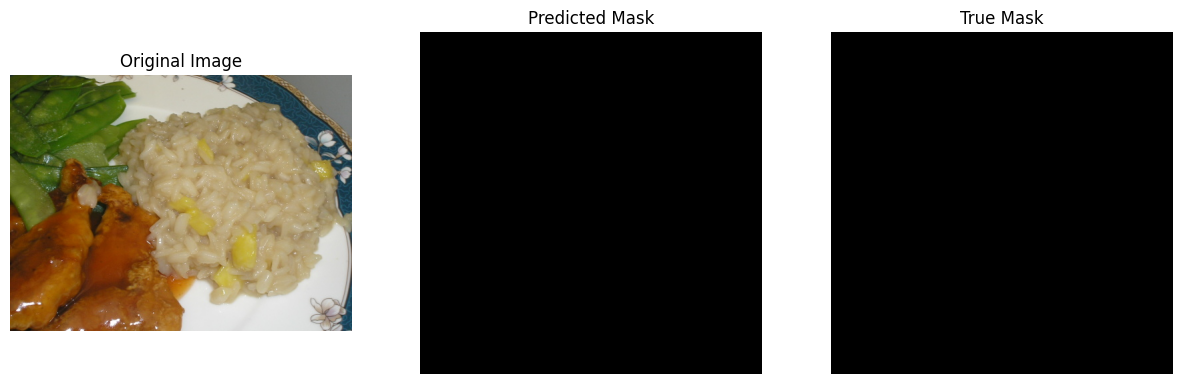

In [ ]:

# Test prediction on a sample
predict_sample(model, train_dataset, idx=0)